In [155]:
import deepxde as dde
import numpy as np
import tensorflow as tf

In [156]:
# Second derivative of displacement w.r.t x (bending curvature)
def ddy(x, y):
    return dde.grad.hessian(y, x)  


# Third derivative of displacement w.r.t x (related to shear force) 
def dddy(x, y):
    return dde.grad.jacobian(ddy(x, y), x)

L = 0.8611 #cantilever length of beam in m
g = 3.177   #constant distributed load due to gravity per length N/m (depends on volume)
EI = 11.367  #Young's modulus x Moment of Inertia

P = 2.893  # point load magnitude in N
x0 = 0.7914  # location of point load from the fixed end

def q(x):
    width = 0.01  # small region to approximate point load (NEW)
    delta = (tf.experimental.numpy.heaviside(x - x0, 1.0) -
             tf.experimental.numpy.heaviside(x - x0 - width, 1.0)) / width  # NEW
    return g + P * delta  # UPDATED

In [157]:
#function representing constant distributed plus concentrated load
def q(x):
    width = 0.01  # tweakable parameter
    delta = tf.exp(-((x - x0) ** 2) / (2 * width ** 2)) / (width * tf.sqrt(2 * np.pi))
    return g + P * delta

In [158]:
EI_material = lambda x: EI

In [159]:
# Define PDE residual for the Euler-Bernoulli static beam equation
def pde(x, y):
    dy_xx = ddy(x, y)
    dy_xxxx = dde.grad.hessian(dy_xx, x)
    # includes concentrated load via q(x)
    return EI_material(x)*dy_xxxx + q(x)    #similar to PDE of EB, or eqn4.5


# Function to identify the left (fixed) boundary x = 0
def boundary_l(x, on_boundary):
    return on_boundary and np.isclose(x[0], 0)  #isclose() function, which checks whether two values are numerically close — accounting for small floating-point errors.


# Function to identify the right (free) boundary x = L
def boundary_r(x, on_boundary):
    return on_boundary and np.isclose(x[0], L)  

# Exact analytical solution for comparison (used as ground truth)  #not required
#"""Analytical deflection for constant g and point load"""
def func(x):
    distributed = (-g * x**2 / (24 * EI)) * (6 * L**2 - 4 * L * x + x**2)
    part1 = (-P * x**2 / (6 * EI)) * (3 * x0 - x)
    part2 = (-P * x0**2 / (6 * EI)) * (3 * x - x0)
    return np.where(x <= x0, distributed + part1, distributed + part2)

In [160]:
# Define the 1D spatial geometry of the beam (domain from 0 to L) #replace with FEM data
geom = dde.geometry.Interval(0, L) 

# Boundary condition: w(0) = 0 (displacement at fixed end)
#On the left boundary (boundary_l), enforce the condition that displacement w(x)=0.
bc1 = dde.DirichletBC(geom, lambda x: 0, boundary_l)   #B in eqn 4.6 #lambda =>For any input x, return 0. 
#Even though there's no explicit variable named w, the output of the network is interpreted as w(𝑥)

# Boundary condition: dw/dx = 0 at fixed end (no rotation)
bc2 = dde.NeumannBC(geom, lambda x: 0, boundary_l)   #A in eqn 4.6

# Boundary condition: d^2w/dx^2 = 0 at free end (no bending moment)
bc3 = dde.OperatorBC(geom, lambda x, y, _: ddy(x, y), boundary_r)

# Boundary condition: d^3w/dx^3 = 0 at free end (no shear force)
bc4 = dde.OperatorBC(geom, lambda x, y, _: dddy(x, y), boundary_r)


In [161]:
# Prepare the PINN training dataset: PDE + boundary conditions + test data
data = dde.data.PDE(   #creates the dataset for solving PDE
    geom,                   #geometry of the domain, defined earlier with geom class
    pde,                    # defined in def pde(x, y) earlier
    [bc1, bc2, bc3, bc4],   #contributes to Ef (C in Eqn 4.6)
    num_domain=20,          #This sets how manypde random collocation points to generate to evaluate PDE
    num_boundary=2,         # randonly pick 2 points near x=0, and 2 points near x=L to enforce all BCs
    ##DeepXDE internally uses slightly jittered/randomized samples to helpapply constraints more robustly amd avoid exact-precision floating point issues
    solution=func,          #analytical soln to compare, defined above. Not for training
    num_test=100,      #DeepXDE generates 100 test points to compare predictions with the exact solution
)

In [162]:
# Define the neural network architecture: input, hidden, output layers
layer_size = [1] + [30] * 4 + [1]

# Use tanh activation function for nonlinearity
activation = "tanh"

# Use Glorot uniform initializer to avoid vanishing gradients
initializer = "Glorot uniform"

# Create the feedforward neural network
net = dde.maps.FNN(layer_size, activation, initializer)

# Create a PINN model using data and neural network
model = dde.Model(data, net)   

# Compile model with optimizer and metric
model.compile("adam", lr=0.001, metrics=["l2 relative error"])

Compiling model...
Building feed-forward neural network...
'build' took 0.212821 s

'compile' took 4.653304 s



In [163]:
# Train the model using Adam optimizer
losshistory, train_state = model.train(epochs=30000, display_every=1000)

Training model...

Step      Train loss                                            Test loss                                             Test metric   
0         [8.94e+01, 0.00e+00, 1.02e-04, 1.89e-04, 4.67e-03]    [3.38e+02, 0.00e+00, 1.02e-04, 1.89e-04, 4.67e-03]    [7.72e-01]    
1000      [3.46e+01, 1.94e-03, 1.12e-03, 8.98e-02, 3.27e-04]    [2.32e+02, 1.94e-03, 1.12e-03, 8.98e-02, 3.27e-04]    [1.55e+00]    
2000      [3.36e+01, 1.45e-03, 4.26e-02, 3.38e-03, 7.54e-02]    [2.29e+02, 1.45e-03, 4.26e-02, 3.38e-03, 7.54e-02]    [5.55e+00]    
3000      [3.21e+01, 2.99e-03, 3.73e-02, 8.64e-02, 1.68e-01]    [2.25e+02, 2.99e-03, 3.73e-02, 8.64e-02, 1.68e-01]    [1.57e+00]    
4000      [1.33e+01, 1.26e-05, 9.43e-02, 3.90e-01, 4.52e-01]    [1.82e+02, 1.26e-05, 9.43e-02, 3.90e-01, 4.52e-01]    [5.50e+00]    
5000      [2.71e+00, 3.69e-04, 8.30e-02, 4.48e-01, 5.13e-01]    [1.92e+02, 3.69e-04, 8.30e-02, 4.48e-01, 5.13e-01]    [5.75e+00]    
6000      [2.64e+00, 2.03e-05, 5.18e-02, 2.66e-01,

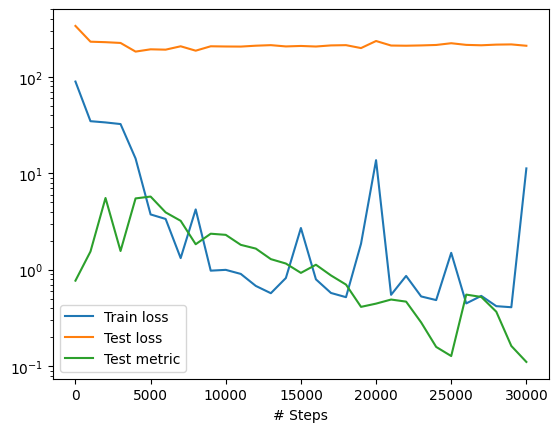

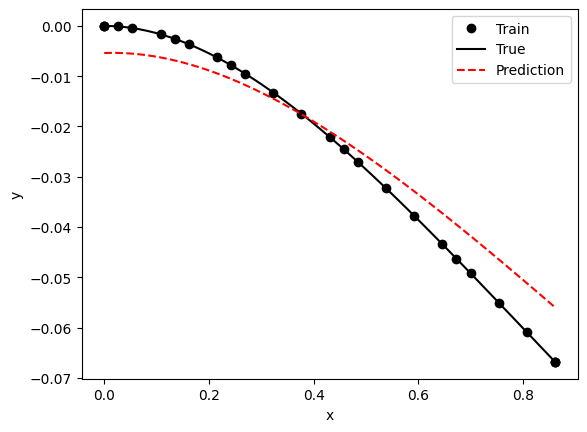

In [164]:
dde.saveplot(losshistory, train_state, issave=False, isplot=True)